# Challenge (Handling Multicollinearity)

## Libraries and Data Pre-processing

In [1]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Downloading data
variables = [
    "^IXIC", 
    "^GSPC", 
    "^OEX",
    "AAPL"
]
start_date = "2020-01-01"
end_date = "2025-01-01"

data = yf.download(variables, start=start_date, end=end_date)["Close"].dropna()

[*********************100%***********************]  4 of 4 completed


In [3]:
# Changing column names
data.rename(columns={
    "^GSPC" : "SP500",
    "^IXIC" : "Nasdaq",
    "^OEX" : "SP100",
    "AAPL": "Apple"
}, inplace=True)

In [4]:
# Getting log returns
df = np.log(data).diff().dropna() * 100

In [5]:
df.head()

Ticker,Apple,SP500,Nasdaq,SP100
Date,,,,
2020-01-03,-0.976963,-0.708491,-0.788621,-0.802179
2020-01-06,0.793689,0.352715,0.560465,0.436665
2020-01-07,-0.471443,-0.280718,-0.031859,-0.375846
2020-01-08,1.595827,0.489047,0.666677,0.560141
2020-01-09,2.101871,0.663321,0.809373,0.751553


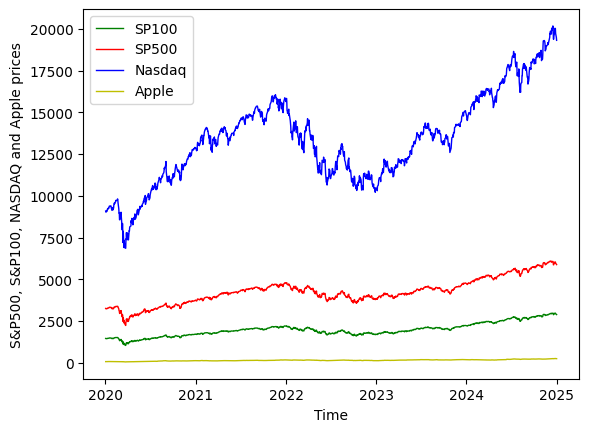

In [6]:
# Prices of the assets over time
plt.plot(data['SP100'], linewidth=1, c="g", label="SP100")
plt.plot(data['SP500'], linewidth=1, c="r", label="SP500")
plt.plot(data['Nasdaq'], linewidth=1, c="b", label="Nasdaq")
plt.plot(data['Apple'], linewidth=1, c="y", label="Apple")
plt.xlabel("Time")
plt.ylabel("S&P500, S&P100, NASDAQ and Apple prices")
plt.legend()
plt.show()

## Detecting Multicollinearity (VIF)

In [7]:
# Creating dataframe to showcase vif
vif_data = pd.DataFrame()
vif_data["Variable"] = df.columns

X = add_constant(df) 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(1, X.shape[1])]

vif_data

,Variable,VIF
0,Apple,3.786102
1,SP500,71.290714
2,Nasdaq,16.207351
3,SP100,110.169058


Except Apple, all the indexes have VIF above 15. Which suggests strong multicollinearity. Which makes sense as a lot of companies are in the indexes.

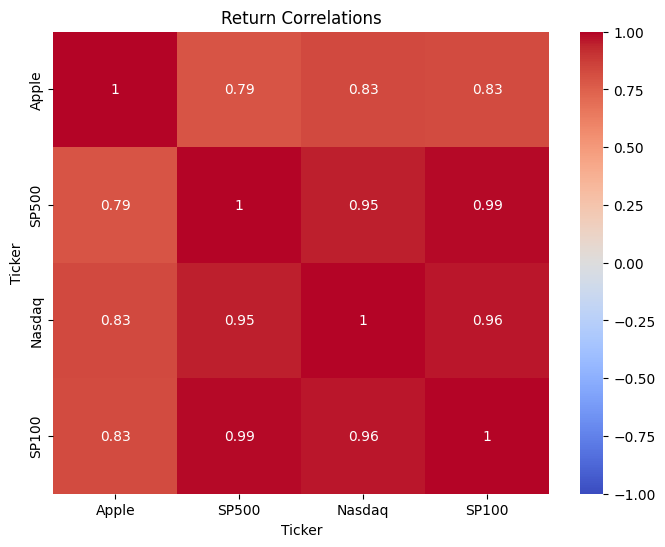

In [8]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Return Correlations")
plt.show()

## Testing OLS with Multicollinear Variables

Dependent variable is Apple stock

In [9]:
# Creating variables for OLS
X = df[["Nasdaq", "SP500", "SP100"]]  
y = df["Apple"]                       

In [10]:
# OLS model creation
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Apple   R-squared (uncentered):                   0.736
Model:                            OLS   Adj. R-squared (uncentered):              0.736
Method:                 Least Squares   F-statistic:                              793.9
Date:                Sat, 05 Jul 2025   Prob (F-statistic):                   3.11e-289
Time:                        00:02:05   Log-Likelihood:                         -1814.1
No. Observations:                1257   AIC:                                      3634.
Df Residuals:                    1254   BIC:                                      3650.
Df Model:                           3                                                  
Covariance Type:                  HAC                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Nasdaq         0.3986      0.084      4.763      0.000       0.235       0.563
SP500         -2.1095      0.223     -9.448      0.000      -2.547      -1.672
SP100          2.8161      0.250     11.275      0.000       2.327       3.306
==============================================================================
Omnibus:                      183.177   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1248.654
Skew:                           0.469   Prob(JB):                    7.22e-272
Kurtosis:                       7.792   Cond. No.                         22.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

**Notes on OLS model:**
- The high F-statistic and very low p-value indicates that the model is statistically significant. 
- The R-squared value of 0.736 suggests that approximately 73.6% of the variance in Apple's returns can be explained by the independent variables.
- But there is the presence of strong multicollinearity, leading to the coefficients being unreliable.

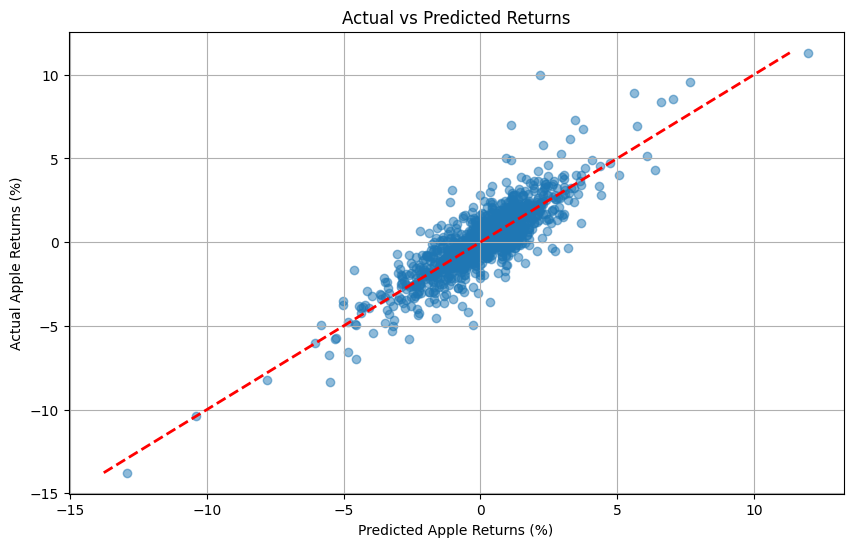

In [11]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, y, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Returns")
plt.xlabel("Predicted Apple Returns (%)")
plt.ylabel("Actual Apple Returns (%)")
plt.grid(True)
plt.show()

A scatter plot of actual vs. predicted returns shows a general linear relationship, though with some dispersion around the ideal line, which is typical for financial time series predictions. 

We can also see the presence of leverage points, affecting the results of the OLS.

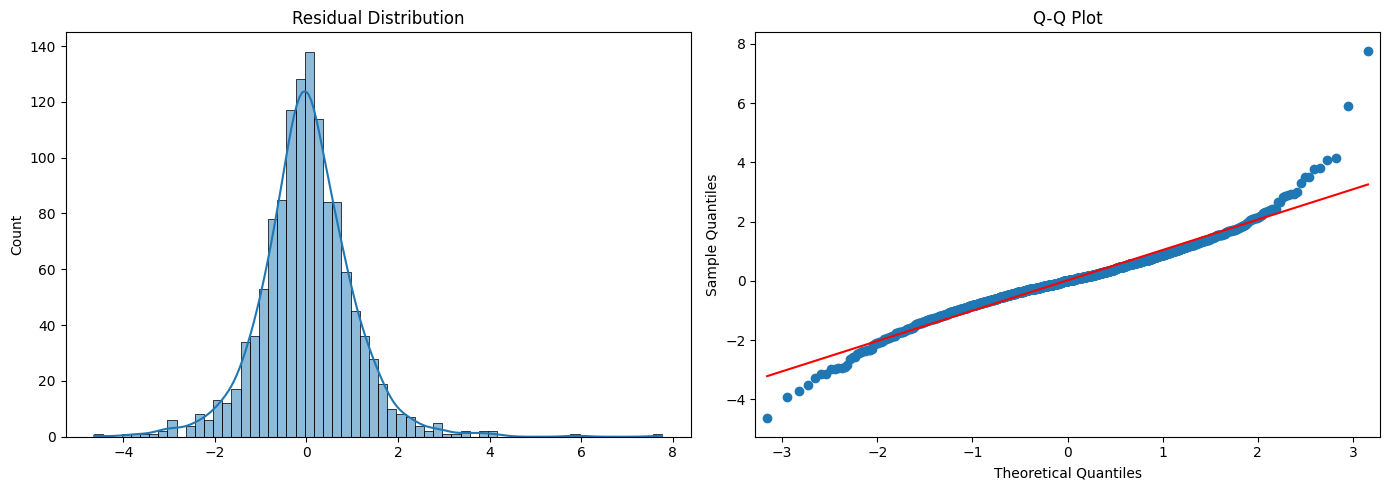

In [12]:
#  Residual diagnostics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(model.resid, kde=True, ax=axes[0])
axes[0].set_title("Residual Distribution")
sm.qqplot(model.resid, line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

Q-Q plot reveals that the residuals are not perfectly normally distributed and exhibit some fat tails, suggesting deviations from the assumptions of OLS, likely due to the nature of financial returns data.

## Principal Component Analysis (PCA)

In [13]:
# Making PCA's
pca = PCA()
principal_components = pca.fit_transform(df)

In [14]:
# Dataframe for PCA
pc_df = pd.DataFrame(
    data=principal_components,
    columns=[f"PC{i+1}" for i in range(principal_components.shape[1])],
    index=df.index
)

In [15]:
pc_df.head()

,PC1,PC2,PC3,PC4
Date,,,,
2020-01-03,-1.780508,0.018381,0.075650,-0.066815
2020-01-06,0.975100,0.134758,0.062544,0.028261
2020-01-07,-0.719778,-0.143635,0.276579,-0.101709
2020-01-08,1.629910,0.636177,-0.024431,0.000376
2020-01-09,2.168255,0.854520,-0.101283,0.007968


In [16]:
# Checking variance of PCAs
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_variance

array([0.90631983, 0.98665815, 0.99898436, 1.        ])

Based on the cummulative variance, the first 2 PC's are enough. As it captures 98% of the data approximately. (Most of the information)

## Testing multicollinearity on the PCA's

In [17]:
# Dataframe for PCA's vif
vif_data1 = pd.DataFrame()
vif_data1["Variable"] = pc_df.columns

X = add_constant(pc_df) 
vif_data1["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(1, X.shape[1])]

vif_data1

,Variable,VIF
0,PC1,1.0
1,PC2,1.0
2,PC3,1.0
3,PC4,1.0


Low VIF, suggesting the removal of multicollinearity, which is showcased in the model.

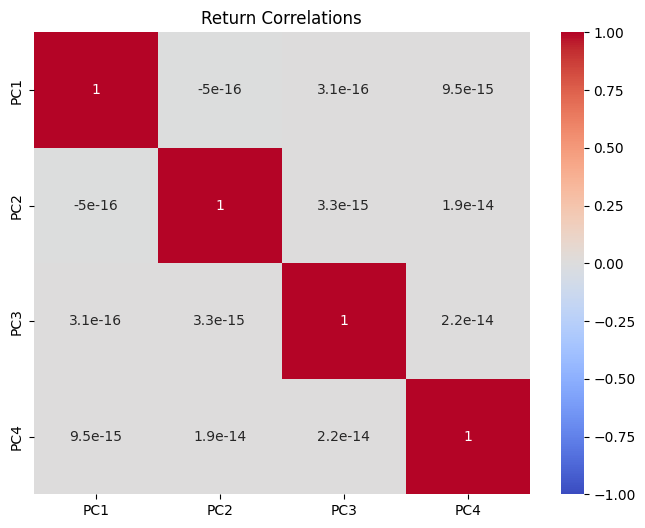

In [18]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pc_df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Return Correlations")
plt.show()

The correlation heatmap of the principal components clearly shows near-zero correlations between them, confirming the effectiveness of PCA in creating orthogonal (uncorrelated) variables.

## OLS on Principal Components

In [19]:
# Making new pca variables
X = pc_df[['PC1', 'PC2']]

In [20]:
# PCA OLS model
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Apple   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.964e+05
Date:                Sat, 05 Jul 2025   Prob (F-statistic):                        0.00
Time:                        00:02:06   Log-Likelihood:                          1086.3
No. Observations:                1257   AIC:                                     -2169.
Df Residuals:                    1255   BIC:                                     -2158.
Df Model:                           2                                                  
Covariance Type:                  HAC                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            0.6101      0.001    566.172      0.000       0.608       0.612
PC2            0.7879      0.003    234.046      0.000       0.781       0.795
==============================================================================
Omnibus:                       97.345   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.328
Skew:                          -0.017   Prob(JB):                    1.53e-111
Kurtosis:                       6.121   Cond. No.                         3.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

**Notes on the OLS model:**
- About 97% of the model explains the variance in apple stock. (R^2)
- High F-statistic and low p-value, showcasing the model is statistically significant.

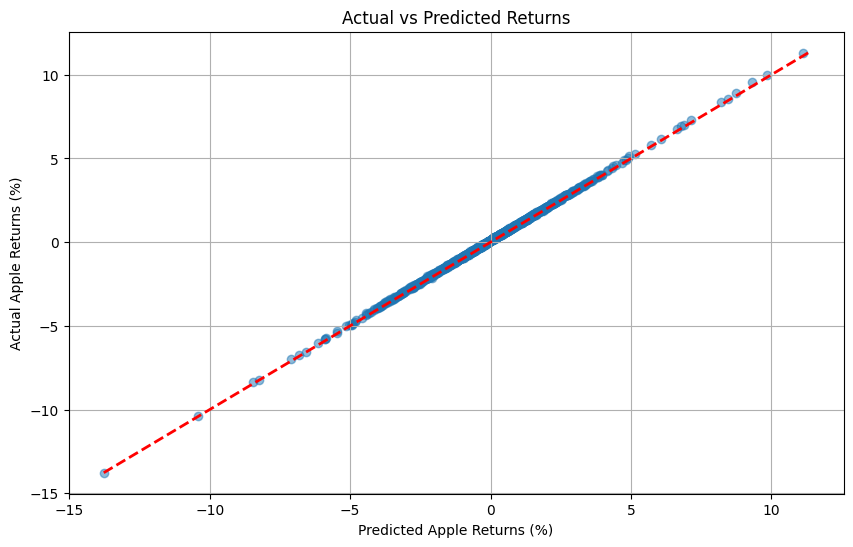

In [21]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, y, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title("Actual vs Predicted Returns")
plt.xlabel("Predicted Apple Returns (%)")
plt.ylabel("Actual Apple Returns (%)")
plt.grid(True)
plt.show()

The scatter plot of actual vs. predicted returns for the PCA-based model shows a much tighter fit around the ideal line compared to the initial OLS model, demonstrating the improved predictive power and stability after addressing multicollinearity

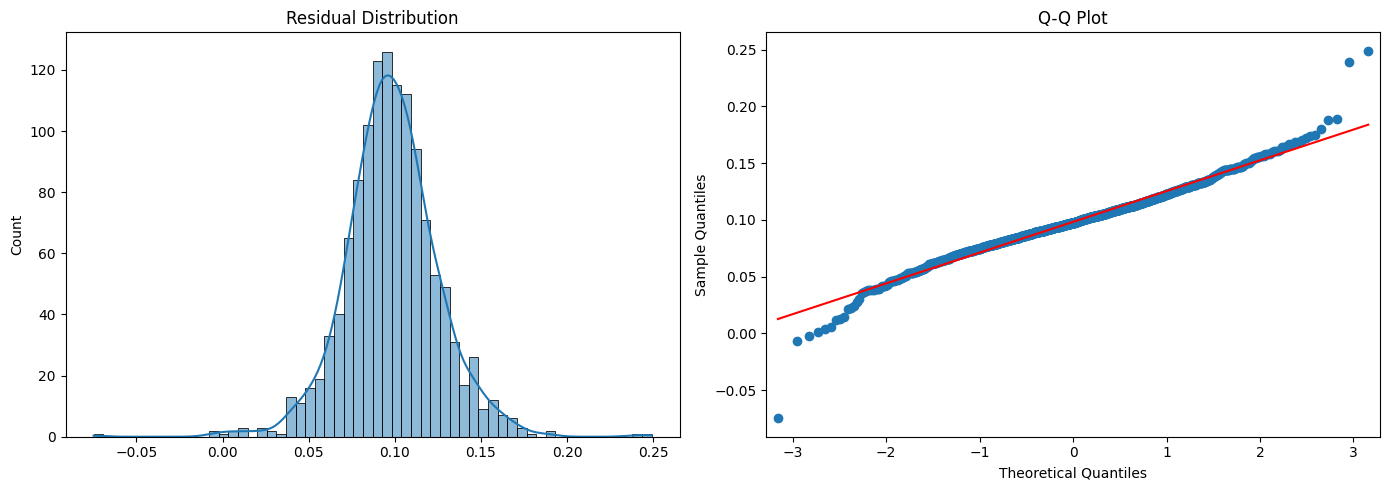

In [22]:
#  Residual diagnostics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(model.resid, kde=True, ax=axes[0])
axes[0].set_title("Residual Distribution")
sm.qqplot(model.resid, line='s', ax=axes[1])
axes[1].set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

The residual diagnostics for the PCA model show a more centralized distribution of residuals compared to the previous model, but still some deviations from perfect normality in the Q-Q plot.

## Model comparison (Conclusion)

This showcases that applying PCA significantly improves the regression model's performance and interpretability. By transforming the correlated original features into uncorrelated principal components, PCA effectively eliminates the multicollinearity issue.

We can see that the model also improved with a higher r^2 and more stable coefficients.

# Challenge) Non-Stationarity and equillibrium

## Libraries and Data Pre-processing

In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import probplot, shapiro

import warnings
warnings.filterwarnings("ignore")

In [24]:
# Downloading data
variables = [
    "GLD",
    "AEM"
]
start_date = "2014-01-01"
end_date = "2025-01-01"

data = yf.download(variables, start=start_date, end=end_date)["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


In [25]:
data.rename(columns={
    variables[0] : "Gold",
    variables[1]: "Aem"
}, inplace=True)

In [26]:
data.head()

Ticker,Aem,Gold
Date,,
2014-01-02,22.658016,118.000000
2014-01-03,22.263823,119.290001
2014-01-06,22.477346,119.500000
2014-01-07,22.419857,118.820000
2014-01-08,22.001026,118.120003


## Checking for Non-stationarity

### Visual

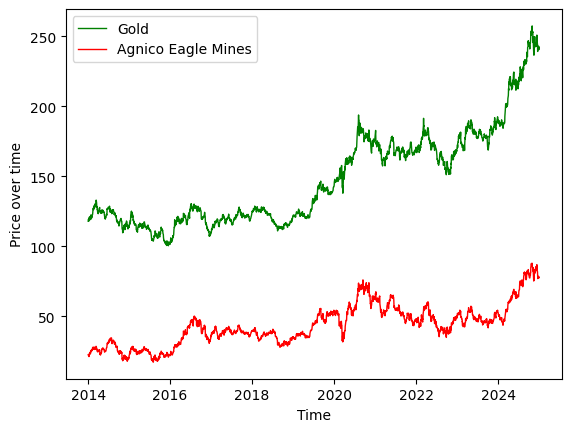

In [27]:
# Scatter plot
plt.plot(data['Gold'], linewidth=1, c="g", label="Gold")
plt.plot(data['Aem'], linewidth=1, c="r", label="Agnico Eagle Mines")
plt.xlabel("Time")
plt.ylabel("Price over time")
plt.legend()
plt.show()

The data does seem to be non-stationary, there is an upwards trend that is present.

### ADF test

In [28]:
test = adfuller(data["Aem"])
print(test[0])

-1.4700254889373574


In [29]:
def adf_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic': r[0], 'pvalue': r[1], 'n_lags': r[2], 'n_observations': r[3]}
    p_value = output['pvalue']
    for key, val in r[4].items():
        output[f'critical_value ({key})'] = val
    if verbose:
        print(f'Augmented Dickey-Fuller Test on "{name}"', '\n', '-'*40)
        for key, val in output.items():
            print(f'{key}: {val}')
        if p_value <= signif:
            print(f"Result: Series is Stationary (p-value = {p_value:.4f} <= {signif})")
        else:
            print(f"Result: Series is Non-Stationary (p-value = {p_value:.4f} > {signif})")
    return p_value 

for name, column in data.items():
    adf_test(column, name=column.name, verbose=True)


Augmented Dickey-Fuller Test on "Aem" 
 ----------------------------------------
test_statistic: -1.4700254889373574
pvalue: 0.5482837811300164
n_lags: 0
n_observations: 2767
critical_value (1%): -3.4327155138680454
critical_value (5%): -2.8625851157957265
critical_value (10%): -2.5673263480950106
Result: Series is Non-Stationary (p-value = 0.5483 > 0.05)
Augmented Dickey-Fuller Test on "Gold" 
 ----------------------------------------
test_statistic: 0.5407688214264116
pvalue: 0.9860609487786862
n_lags: 3
n_observations: 2764
critical_value (1%): -3.432718083748152
critical_value (5%): -2.862586250752157
critical_value (10%): -2.5673269523447004
Result: Series is Non-Stationary (p-value = 0.9861 > 0.05)


Based on the ADF test we can say both the assets are non-stationary

### KPSS test

In [30]:
def run_kpss_test(series, series_name, regression_type='c', alpha=0.05):
    print(f"\n--- KPSS Test for: {series_name} (Regression type: '{regression_type}') ---")
    
    kpss_statistic, p_value, n_lags, critical_values = kpss(series, regression=regression_type)

    print(f"KPSS Statistic: {kpss_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Number of Lags Used: {n_lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}%: {value:.4f}")

    if p_value < alpha:
        print(f"Conclusion: Reject the null hypothesis (H0). The series '{series_name}' is likely NON-STATIONARY at {alpha*100}% significance level.")
    else:
        print(f"Conclusion: Fail to reject the null hypothesis (H0). The series '{series_name}' is likely STATIONARY at {alpha*100}% significance level.")


run_kpss_test(data['Gold'], 'Gold Price')
run_kpss_test(data['Aem'], 'Agnico Eagle Mines Price')


--- KPSS Test for: Gold Price (Regression type: 'c') ---
KPSS Statistic: 7.1725
P-value: 0.0100
Number of Lags Used: 31
Critical Values:
  10%%: 0.3470
  5%%: 0.4630
  2.5%%: 0.5740
  1%%: 0.7390
Conclusion: Reject the null hypothesis (H0). The series 'Gold Price' is likely NON-STATIONARY at 5.0% significance level.

--- KPSS Test for: Agnico Eagle Mines Price (Regression type: 'c') ---
KPSS Statistic: 5.5165
P-value: 0.0100
Number of Lags Used: 31
Critical Values:
  10%%: 0.3470
  5%%: 0.4630
  2.5%%: 0.5740
  1%%: 0.7390
Conclusion: Reject the null hypothesis (H0). The series 'Agnico Eagle Mines Price' is likely NON-STATIONARY at 5.0% significance level.


Again based on the KPSS test we can say the data is non-stationary.

## Cointegration

### Engle-Granger Two-Step Method

In [31]:
# Gold ~ AEM

In [32]:
# OLS
model = OLS(data['Gold'], data['Aem'])
results = model.fit()

In [33]:
# Residuals
residuals = results.resid
print("Residuals from OLS regression:")
print(residuals.head())

Residuals from OLS regression:
Date
2014-01-02    44.075627
2014-01-03    46.651730
2014-01-06    46.165083
2014-01-07    45.672648
2014-01-08    46.339135
dtype: float64


In [34]:
# ADF on cointegration
adf_test_result = adfuller(residuals)
print('\nADF Statistic for Residuals:', adf_test_result[0])
print('p-value for Residuals:', adf_test_result[1])
print('Critical Values:', adf_test_result[4])


ADF Statistic for Residuals: -3.154030671524103
p-value for Residuals: 0.022804585057273317
Critical Values: {'1%': np.float64(-3.4327155138680454), '5%': np.float64(-2.8625851157957265), '10%': np.float64(-2.5673263480950106)}


In [35]:
# Interpretation
alpha = 0.05
if adf_test_result[1] < alpha:
    print(f"Conclusion: The p-value ({adf_test_result[1]:.4f}) is less than {alpha}. Reject the null hypothesis.")
    print("The residuals are stationary, indicating that the series 'Gold Price' and 'Agnico Eagle Mines Price' are cointegrated.")
else:
    print(f"Conclusion: The p-value ({adf_test_result[1]:.4f}) is greater than or equal to {alpha}. Fail to reject the null hypothesis.")
    print("The residuals are non-stationary, indicating that the series 'Gold Price' and 'Agnico Eagle Mines Price' are NOT cointegrated.")

Conclusion: The p-value (0.0228) is less than 0.05. Reject the null hypothesis.
The residuals are stationary, indicating that the series 'Gold Price' and 'Agnico Eagle Mines Price' are cointegrated.


Based on the test we can say the data are cointegrated.

### Johansen Cointegration Test

In [36]:
def johansen_test(series, alpha=0.05):

    model_data = series.astype(float)

    print(f"\nPerforming Johansen Cointegration Test for: {', '.join(series.columns)}")
    # trend exists so det_order = 1
    johan_result = coint_johansen(model_data, det_order=1, k_ar_diff=3)

    # Critical values for 90%, 95%, 99% (Only 95%)
    critical_values = johan_result.cvm
        
    # Test for trace statistic
    print("\nTrace Statistic Test:")
    for i in range(series.shape[1]):
        if johan_result.lr1[i] > critical_values[i, 1]:  
            print(f"Rank {i}: Trace Stat = {johan_result.lr1[i]:.2f}, Critical Value (95%) = {critical_values[i, 1]:.2f} => Reject H0 (at most {i} cointegrating relations)")
        else:
            print(f"Rank {i}: Trace Stat = {johan_result.lr1[i]:.2f}, Critical Value (95%) = {critical_values[i, 1]:.2f} => Fail to Reject H0 (at most {i} cointegrating relations)")
        
    # Test for eigenvalue statistic
    print("\nEigenvalue Statistic Test (Max-Eigenvalue Test):")
    for i in range(series.shape[1]):

        if johan_result.lr2[i] > critical_values[i, 1]:  
            print(f"Rank {i}: Max-Eigenvalue Stat = {johan_result.lr2[i]:.2f}, Critical Value (95%) = {critical_values[i, 1]:.2f} => Reject H0 ({i} cointegrating relations)")
        else:
            print(f"Rank {i}: Max-Eigenvalue Stat = {johan_result.lr2[i]:.2f}, Critical Value (95%) = {critical_values[i, 1]:.2f} => Fail to Reject H0 ({i} cointegrating relations)")

    print("\nEigenvectors (Cointegrating Vectors):\n", johan_result.evec)
    print("\nEigenvalues:\n", johan_result.eig)
    print("\nTrace Statistics (lr1):\n", johan_result.lr1)
    print("\nMax-Eigenvalue Statistics (lr2):\n", johan_result.lr2)
    print("\nCritical Values (90%, 95%, 99% for lr1 and lr2 respectively):\n", johan_result.cvm)

johansen_test(data[['Gold', 'Aem']], alpha=0.1)


Performing Johansen Cointegration Test for: Gold, Aem

Trace Statistic Test:
Rank 0: Trace Stat = 13.66, Critical Value (95%) = 17.15 => Fail to Reject H0 (at most 0 cointegrating relations)
Rank 1: Trace Stat = 2.98, Critical Value (95%) = 3.84 => Fail to Reject H0 (at most 1 cointegrating relations)

Eigenvalue Statistic Test (Max-Eigenvalue Test):
Rank 0: Max-Eigenvalue Stat = 10.68, Critical Value (95%) = 17.15 => Fail to Reject H0 (0 cointegrating relations)
Rank 1: Max-Eigenvalue Stat = 2.98, Critical Value (95%) = 3.84 => Fail to Reject H0 (1 cointegrating relations)

Eigenvectors (Cointegrating Vectors):
 [[ 0.03671138 -0.07236179]
 [-0.14177771  0.03277274]]

Eigenvalues:
 [0.00385616 0.00107877]

Trace Statistics (lr1):
 [13.66234423  2.98331849]

Max-Eigenvalue Statistics (lr2):
 [10.67902574  2.98331849]

Critical Values (90%, 95%, 99% for lr1 and lr2 respectively):
 [[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


## VECM model

In [37]:
# Optimal lag based on BIC
print("\n--- Determining Optimal Lag Order for VAR (pre-VECM) ---")
model_var = VAR(data)
lag_results = model_var.select_order(maxlags=10)
optimal_lags = lag_results.aic 
print(f"Optimal lag order for VAR (based on AIC): {optimal_lags}")


--- Determining Optimal Lag Order for VAR (pre-VECM) ---
Optimal lag order for VAR (based on AIC): 3


In [38]:
k_rank = 1  

vecm_lags = 3

vecm_model = VECM(data, coint_rank=k_rank, k_ar_diff=vecm_lags, deterministic="co")
vecm_res = vecm_model.fit()

In [39]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0293,0.026,-1.122,0.262,-0.081,0.022
L1.Aem,-0.0311,0.027,-1.161,0.245,-0.083,0.021
L1.Gold,0.0309,0.020,1.523,0.128,-0.009,0.071
L2.Aem,0.0390,0.027,1.455,0.146,-0.014,0.091
L2.Gold,-0.0322,0.020,-1.587,0.112,-0.072,0.008
L3.Aem,0.0508,0.027,1.898,0.058,-0.002,0.103
L3.Gold,-0.0167,0.020,-0.826,0.409,-0.057,0.023
,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0213,0.034,0.618,0.536,-0.046,0.089
L1.Aem,0.0338,0.035,0.957,0.339,-0.035,0.103


In [40]:
# Downloading data
variables1 = [
    "GLD",
    "AEM"
]
start_date1 = "2024-12-31"
end_date1 = "2025-07-01"

data1 = yf.download(variables1, start=start_date1, end=end_date1)["Close"].dropna()

[*********************100%***********************]  2 of 2 completed


In [41]:
data1.rename(columns={
    "GLD" : "Gold",
    "AEM": "Aem"
}, inplace=True)

In [42]:
data1.head()

Ticker,Aem,Gold
Date,,
2024-12-31,77.881004,242.130005
2025-01-02,81.645103,245.419998
2025-01-03,80.738937,243.490005
2025-01-06,79.324913,243.190002
2025-01-07,80.808640,244.559998


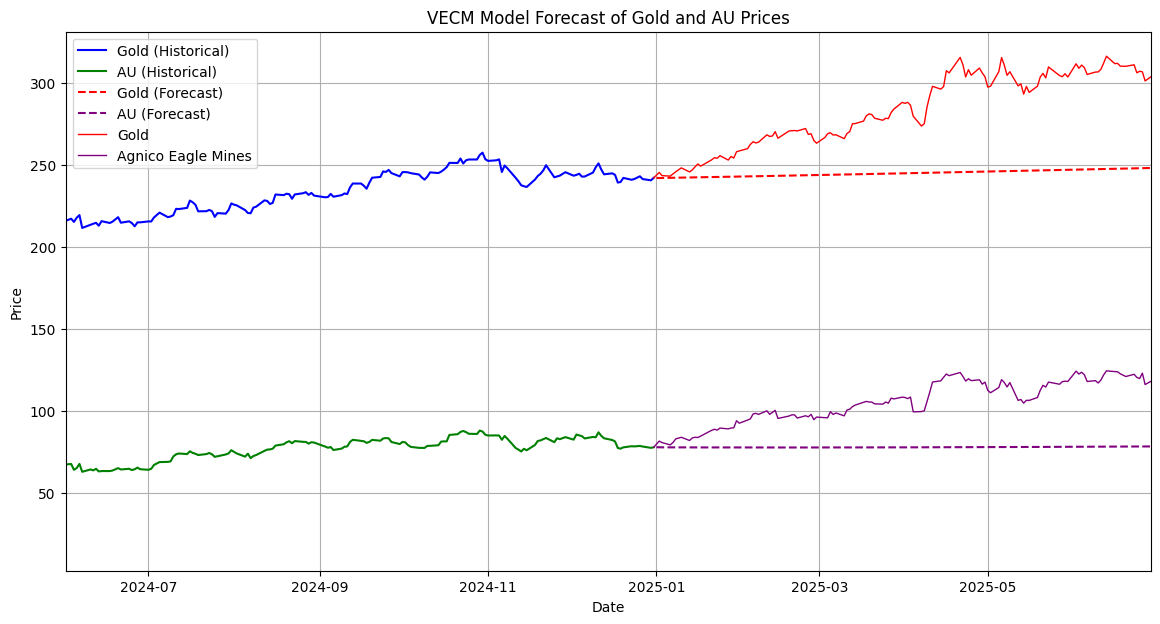

In [43]:
n_forecast_steps = 30 * 6


forecast_output = vecm_res.predict(steps=n_forecast_steps)

# Convert forecast to a DataFrame
column_names = data.columns
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_forecast_steps, freq='D')

forecast_df = pd.DataFrame(forecast_output, index=forecast_index, columns=column_names)

plt.figure(figsize=(14, 7))

# Plot the historical data
plt.plot(data.index, data['Gold'], label='Gold (Historical)', color='blue')
plt.plot(data.index, data['Aem'], label='AU (Historical)', color='green')

# Plot the forecasted data
plt.plot(forecast_df.index, forecast_df['Gold'], label='Gold (Forecast)', linestyle='--', color='red')
plt.plot(forecast_df.index, forecast_df['Aem'], label='AU (Forecast)', linestyle='--', color='purple')

# Plot the actual data
plt.plot(data1['Gold'], linewidth=1, c="red", label="Gold")
plt.plot(data1['Aem'], linewidth=1, c="purple", label="Agnico Eagle Mines")

plt.title('VECM Model Forecast of Gold and AU Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xlim(pd.Timestamp('2024-06-01'), forecast_df.index.max())
plt.show()

## Diagostics

In [44]:
# Residuals
raw_residuals = vecm_res.resid
residuals = pd.DataFrame(raw_residuals, index=data.index[vecm_res.k_ar:], columns=data.columns)

print("Shape of residuals:", residuals.shape)
print("\nFirst 5 rows of residuals:\n", residuals.head())

Shape of residuals: (2764, 2)

First 5 rows of residuals:
 Ticker           Aem      Gold
Date                          
2014-01-08 -0.477119 -0.779368
2014-01-09 -0.786276  0.173758
2014-01-10  0.863809  1.705766
2014-01-13  1.017288  0.780999
2014-01-14 -0.728746 -1.134991


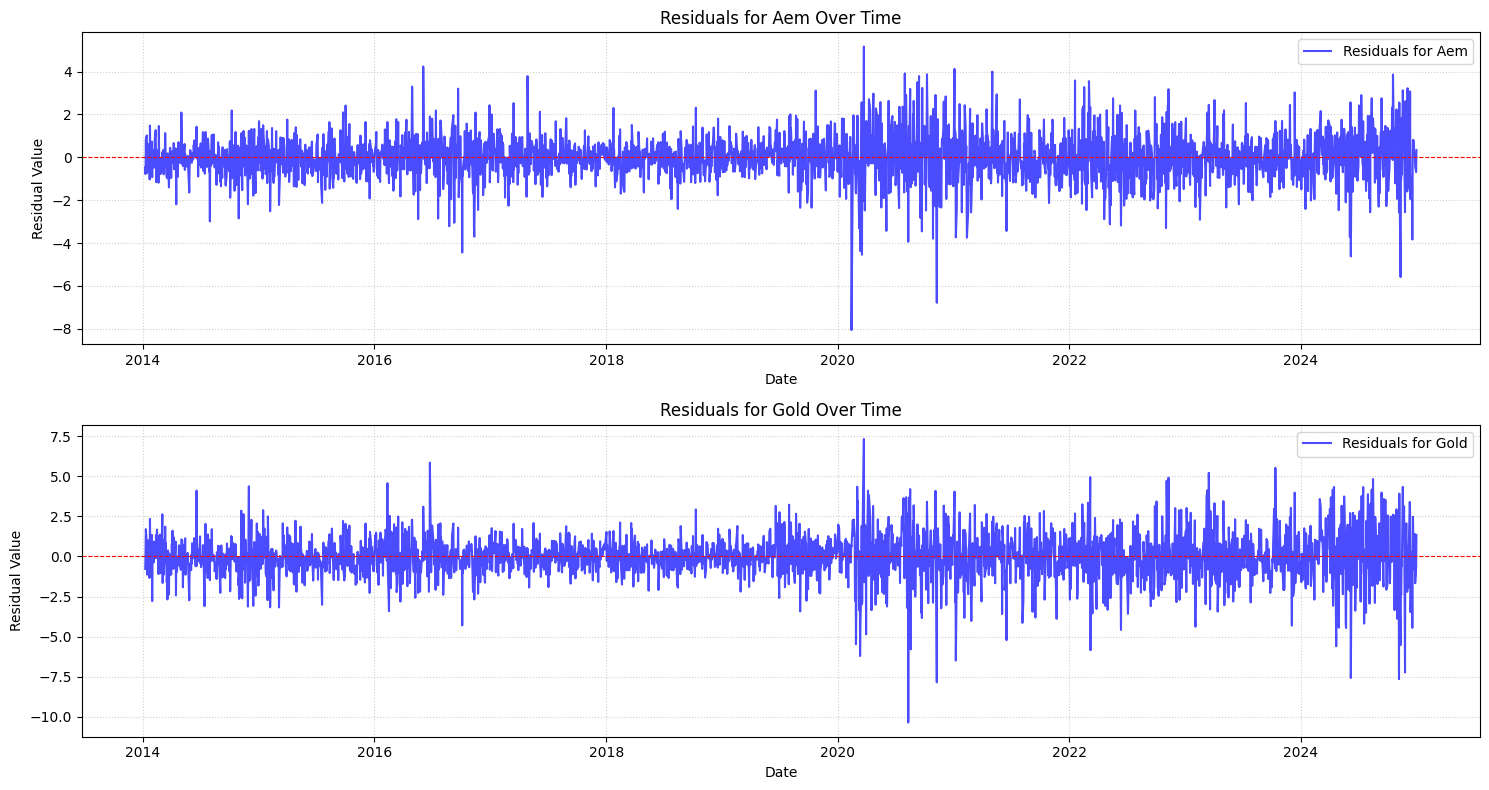

In [45]:
# Residuals over time
plt.figure(figsize=(15, 8))
for i, col in enumerate(residuals.columns):
    plt.subplot(len(residuals.columns), 1, i + 1)
    plt.plot(residuals.index, residuals[col], label=f'Residuals for {col}', color='blue', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
    plt.title(f'Residuals for {col} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
plt.tight_layout()
plt.show()

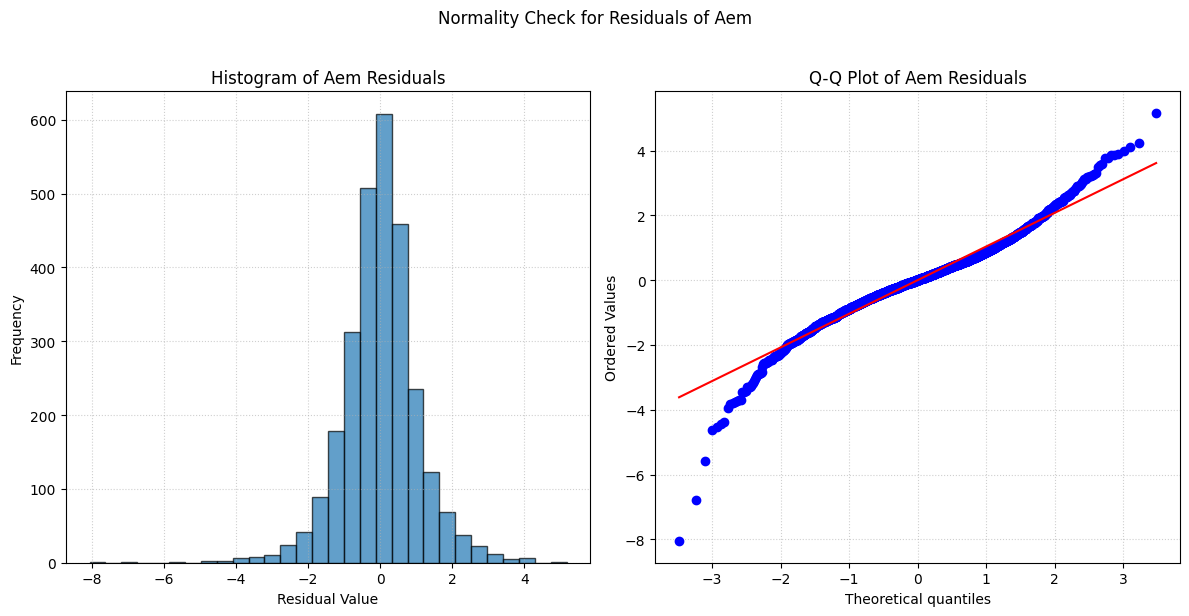

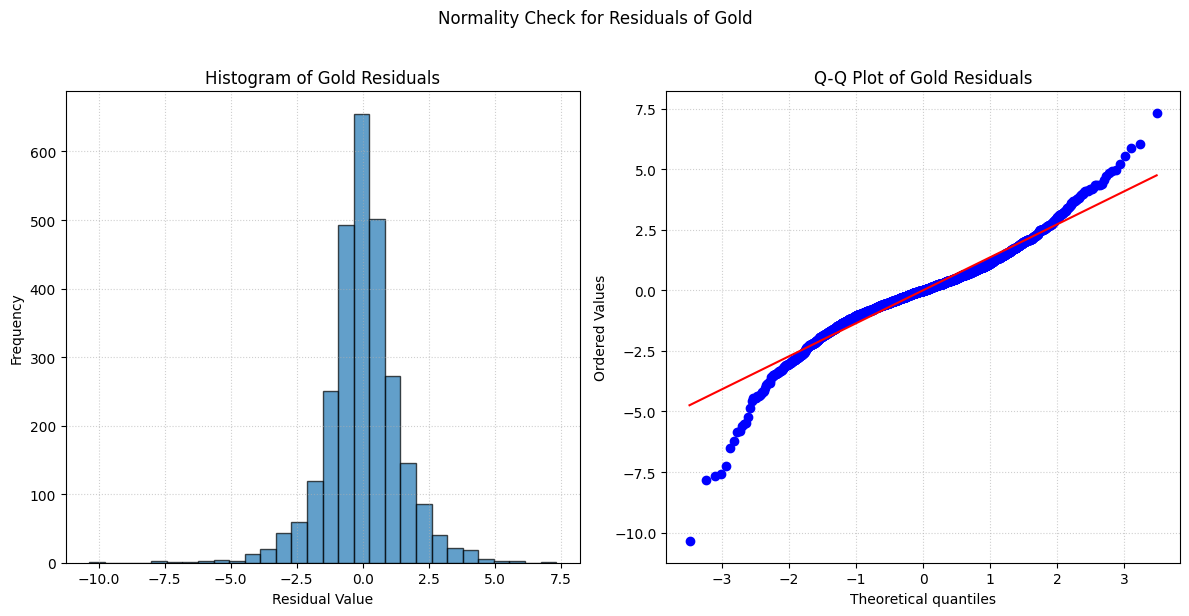

In [46]:
# QQ plot and histogram
for col in residuals.columns:
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Normality Check for Residuals of {col}', y=1.02)

    # Histogram
    plt.subplot(1, 2, 1)
    residuals[col].hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram of {col} Residuals')
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', alpha=0.6)

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    probplot(residuals[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col} Residuals')
    plt.grid(True, linestyle=':', alpha=0.6)

    plt.tight_layout()
    plt.show()